In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline

In [182]:
import gymnasium as gym
env = gym.make("ALE/KungFuMaster-v5")

In [208]:
def transform(state):
    out = torch.from_numpy(state).permute(2, 1, 0)
    out = out.float() / 255.0
    out = F.avg_pool2d(out, kernel_size=2, stride=2)
    out = out[:, :, 52:84] # crop to game field
    return out

def readhealth(state):
    return (state[45, 50:82, 1] > 128).astype(float).mean()

def rollout(env, agent, max_steps=1000):
    result = []
    state, info = env.reset()
    state = transform(state)
    health = info['lives']
    for _ in range(max_steps):
        action = agent(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        next_health = 0 if info['lives'] == 0 else (info['lives'] - 1) + readhealth(next_state)
        reward += (next_health - health) * 100 # penalize health loss

        result.append((state, action, reward))
        state = transform(next_state)
        health = next_health
        if terminated or truncated:
            break
    return result

def batches(env, agent, batch_size, num_rollouts, max_steps=1000, reward_discount=0.99):
    games = []
    gamea = []
    gamer = []
    for _ in range(num_rollouts):
        game = rollout(env, agent, max_steps)
        # score using discounted rewards
        acc_reward = 0
        for i in range(len(game) - 1, -1, -1):
            acc_reward = game[i][2] + reward_discount * acc_reward
            games.append(game[i][0])
            gamea.append(game[i][1])
            gamer.append(acc_reward)

    while len(games) >= batch_size:
        yield games[:batch_size], gamea[:batch_size], gamer[:batch_size]
        games = games[batch_size:]
        gamea = gamea[batch_size:]
        gamer = gamer[batch_size:]

@torch.no_grad()
def agent(state, net, device):
    state = state.float().to(device)
    pred = net(state)
    assert(len(pred.shape) == 1)
    prob = F.softmax(pred, dim=0)
    prob = prob.cpu() # multinomial is way slower in CUDA, even once you account for the transfer time
    act = torch.multinomial(prob, 1)
    return act.item()

In [209]:
class AtariNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True)
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(torch.prod(torch.tensor(o.size())))

    def forward(self, x):
        conv_out = self.conv(x)
        # flatten each sample in the batch
        conv_out = conv_out.view(x.shape[0], -1) if len(x.shape) == 4 else conv_out.flatten()
        pred = self.fc(conv_out)
        return pred

Epoch 0 took 32.40s, reward: 16.45, loss: 43.58
Epoch 1 took 32.10s, reward: 25.77, loss: 67.71
Epoch 2 took 32.20s, reward: 24.72, loss: 64.71
Epoch 3 took 31.65s, reward: 38.63, loss: 101.21
Epoch 4 took 30.68s, reward: 31.29, loss: 81.93
Epoch 5 took 32.07s, reward: 49.04, loss: 127.95
Epoch 6 took 30.72s, reward: 36.33, loss: 95.04
Epoch 7 took 30.91s, reward: 50.56, loss: 132.20
Epoch 8 took 31.58s, reward: 50.81, loss: 132.88
Epoch 9 took 32.71s, reward: 36.77, loss: 95.77
Epoch 10 took 33.16s, reward: 51.16, loss: 133.02
Epoch 11 took 31.91s, reward: 51.57, loss: 133.74
Epoch 12 took 31.54s, reward: 69.89, loss: 179.71
Epoch 13 took 34.77s, reward: 88.81, loss: 227.03
Epoch 14 took 33.83s, reward: 80.49, loss: 206.09
Epoch 15 took 32.19s, reward: 95.43, loss: 243.16
Epoch 16 took 32.47s, reward: 102.79, loss: 261.30
Epoch 17 took 32.83s, reward: 87.15, loss: 220.89
Epoch 18 took 32.83s, reward: 81.85, loss: 208.39
Epoch 19 took 32.86s, reward: 92.43, loss: 234.10
Epoch 20 took 3

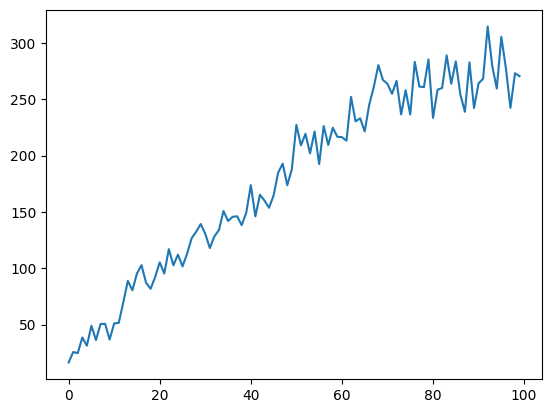

In [219]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AtariNet((3, 32, 80), env.action_space.n)
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

num_epochs = 100
num_rollouts = 32
batch_size = 128

epoch_rewards = []

for epoch in range(num_epochs):
    epoch_reward = 0
    epoch_loss = 0
    epoch_start = time.time()
    num_batches = 0

    for bs, ba, br in batches(env, lambda s: agent(s, net, device), batch_size=batch_size, num_rollouts=num_rollouts):
        bs = torch.stack(bs)
        ba = torch.tensor(ba, dtype=torch.long)
        br = torch.tensor(br, dtype=torch.float)

        bs = bs.float()
        bs, ba, br = bs.to(device), ba.to(device), br.to(device)

        pred = net(bs)
        log_prob = F.log_softmax(pred, dim=-1)
        loss = (-log_prob[torch.arange(0, ba.shape[0]), ba] * br).mean()

        epoch_reward += br.mean().item()
        epoch_loss += loss.item()
        num_batches += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_reward /= num_batches
    epoch_loss /= num_batches

    print(f'Epoch {epoch} took {time.time() - epoch_start:.2f}s, reward: {epoch_reward:.2f}, loss: {epoch_loss:.2f}')

    epoch_rewards.append(epoch_reward)

    torch.save(net.state_dict(), 'kungfu.pth')

plt.plot(epoch_rewards)

In [220]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = AtariNet((3, 32, 80), env.action_space.n).to(device)
net.load_state_dict(torch.load('kungfu.pth', weights_only=True))

testenv = gym.make("ALE/KungFuMaster-v5")
observation, info = testenv.reset()
total_steps = 0
total_reward = 0

while True:
    action = agent(transform(observation), net, device)
    observation, reward, terminated, truncated, info = testenv.step(action)
    total_reward += reward
    total_steps += 1

    if terminated or truncated:
        break

testenv.close()

print(f'Total reward: {total_reward}, steps {total_steps}')

/home/zeux/.local/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Total reward: 6900.0, steps 2036
